In [3]:
# RFM analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("=== Day 3: RFM Analysis & Customer Segmentation ===")

=== Day 3: RFM Analysis & Customer Segmentation ===


In [4]:
# Load clean data
df = pd.read_csv('../data/clean_sales.csv')
df['invoicedate'] = pd.to_datetime(df['invoicedate'])

print(f"Dataset: {len(df):,} transactions, {df['customerid'].nunique():,} customers")
print(f"Date range: {df['invoicedate'].min()} to {df['invoicedate'].max()}")

# Set analysis snapshot date (day after last transaction)
snapshot_date = df['invoicedate'].max() + pd.Timedelta(days=1)
print(f"Analysis snapshot date: {snapshot_date}")

Dataset: 392,692 transactions, 4,338 customers
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Analysis snapshot date: 2011-12-10 12:50:00



=== Calculating RFM Metrics ===
RFM dataset: 4,338 customers

RFM Summary:
       recency  frequency   monetary
count  4338.00    4338.00    4338.00
mean     92.54       4.27    2048.69
std     100.01       7.70    8985.23
min       1.00       1.00       3.75
25%      18.00       1.00     306.48
50%      51.00       2.00     668.57
75%     142.00       5.00    1660.60
max     374.00     209.00  280206.02


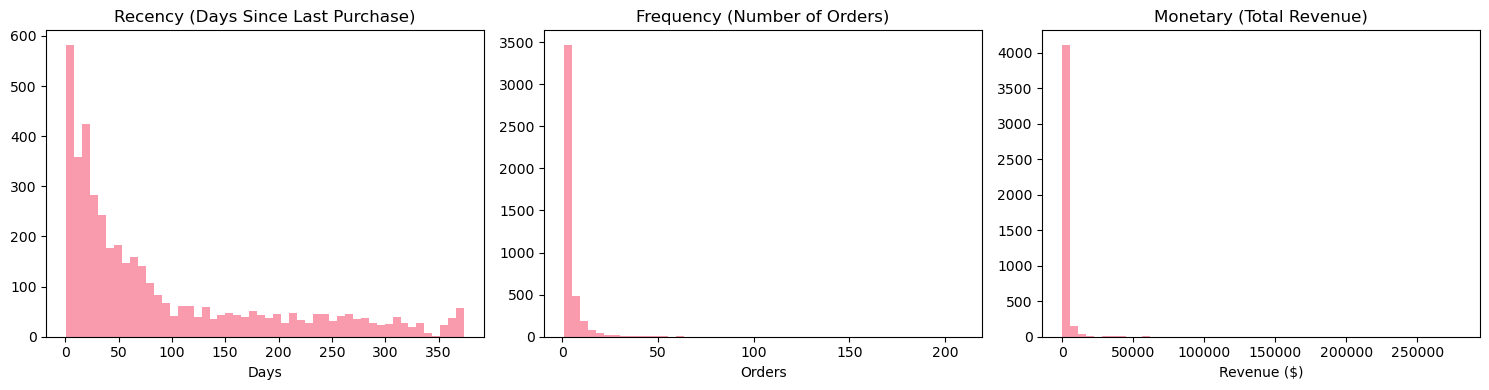

In [5]:
# Calculate RFM metrics
print("\n=== Calculating RFM Metrics ===")

rfm = df.groupby('customerid').agg({
    'invoicedate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'invoiceno': 'nunique',                                   # Frequency  
    'total_amount': 'sum'                                     # Monetary
}).rename(columns={
    'invoicedate': 'recency',
    'invoiceno': 'frequency', 
    'total_amount': 'monetary'
})

# Remove customers with negative monetary value (returns only)
rfm = rfm[rfm['monetary'] > 0]

print(f"RFM dataset: {len(rfm):,} customers")
print("\nRFM Summary:")
print(rfm.describe().round(2))

# Quick visualization of RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(rfm['recency'], bins=50, alpha=0.7)
axes[0].set_title('Recency (Days Since Last Purchase)')
axes[0].set_xlabel('Days')

axes[1].hist(rfm['frequency'], bins=50, alpha=0.7)
axes[1].set_title('Frequency (Number of Orders)')
axes[1].set_xlabel('Orders')

axes[2].hist(rfm['monetary'], bins=50, alpha=0.7)
axes[2].set_title('Monetary (Total Revenue)')
axes[2].set_xlabel('Revenue ($)')

plt.tight_layout()
plt.savefig('../visuals/rfm_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


=== Finding Optimal Number of Clusters ===


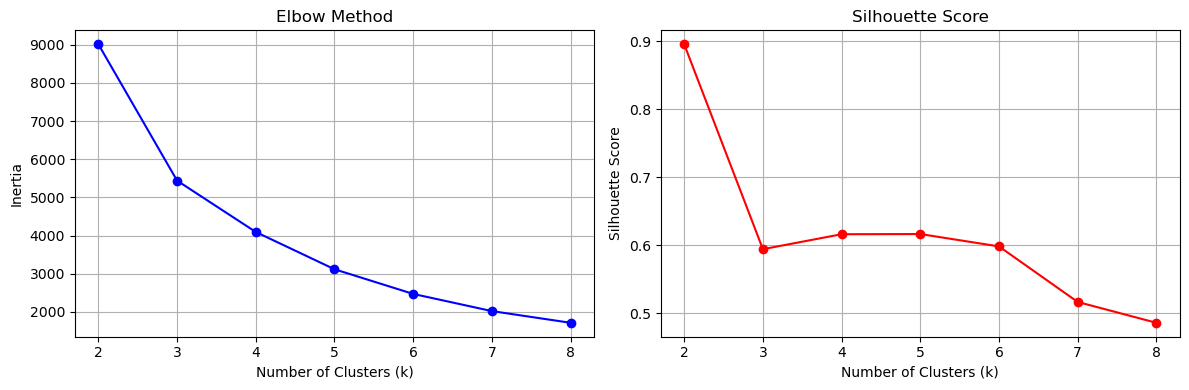

k=2: Silhouette Score = 0.896
k=3: Silhouette Score = 0.594
k=4: Silhouette Score = 0.616
k=5: Silhouette Score = 0.617
k=6: Silhouette Score = 0.598
k=7: Silhouette Score = 0.517
k=8: Silhouette Score = 0.486

Optimal k based on silhouette score: 2


In [6]:
# Scale RFM features for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

print("\n=== Finding Optimal Number of Clusters ===")

# Test different numbers of clusters
k_range = range(2, 9)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, cluster_labels))

# Plot elbow method and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.savefig('../visuals/cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Print scores
for k, sil_score in zip(k_range, silhouette_scores):
    print(f"k={k}: Silhouette Score = {sil_score:.3f}")

# Choose optimal k (you can adjust based on the plots)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on silhouette score: {optimal_k}")

In [7]:
# Final clustering with optimal k
print(f"\n=== Final Clustering with k={optimal_k} ===")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['segment'] = kmeans_final.fit_predict(rfm_scaled)

print(f"Final silhouette score: {silhouette_score(rfm_scaled, rfm['segment']):.3f}")

# Analyze segments
print("\n=== Segment Analysis ===")
segment_summary = rfm.groupby('segment').agg({
    'recency': ['mean', 'median'],
    'frequency': ['mean', 'median'], 
    'monetary': ['mean', 'median', 'sum'],
    'segment': 'count'
}).round(2)

segment_summary.columns = ['_'.join(col).strip() for col in segment_summary.columns]
segment_summary = segment_summary.rename(columns={'segment_count': 'customer_count'})

print(segment_summary)

# Calculate segment percentages
segment_summary['percentage'] = (segment_summary['customer_count'] / len(rfm) * 100).round(1)
print(f"\nSegment sizes:")
for seg in range(optimal_k):
    count = segment_summary.loc[seg, 'customer_count']
    pct = segment_summary.loc[seg, 'percentage']
    print(f"Segment {seg}: {count:,} customers ({pct}%)")


=== Final Clustering with k=2 ===
Final silhouette score: 0.896

=== Segment Analysis ===
         recency_mean  recency_median  frequency_mean  frequency_median  \
segment                                                                   
0               93.06            51.0            3.90               2.0   
1                6.04             3.5           66.42              53.0   

         monetary_mean  monetary_median  monetary_sum  customer_count  
segment                                                                
0              1543.54           662.56    6655730.86            4312  
1             85826.08         59697.42    2231478.03              26  

Segment sizes:
Segment 0: 4,312 customers (99.4%)
Segment 1: 26 customers (0.6%)


In [8]:
# Create segment profiles and assign names
print("\n=== Segment Naming & Profiling ===")

# Calculate segment characteristics for naming
segment_chars = rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(1)

# Define segment names based on RFM characteristics
segment_names = {}
segment_actions = {}

# You'll need to adjust these based on your actual segment characteristics
# This is a template - analyze your segment_chars to assign appropriate names

for seg in range(optimal_k):
    r = segment_chars.loc[seg, 'recency']
    f = segment_chars.loc[seg, 'frequency'] 
    m = segment_chars.loc[seg, 'monetary']
    
    # Example naming logic (adjust based on your data)
    if r <= 50 and f >= 3 and m >= 500:
        segment_names[seg] = "Champions"
        segment_actions[seg] = [
            "Reward with exclusive products/early access",
            "Request reviews and referrals", 
            "Upsell premium products",
            "Use as brand ambassadors"
        ]
    elif r <= 100 and f >= 2 and m >= 200:
        segment_names[seg] = "Loyal Customers"  
        segment_actions[seg] = [
            "Provide member-only deals",
            "Recommend complementary products",
            "Ask for feedback on new products",
            "Increase purchase frequency with bundles"
        ]
    elif r > 200 and f == 1 and m < 100:
        segment_names[seg] = "Need Activation"
        segment_actions[seg] = [
            "Send onboarding series with product education",
            "Offer limited-time discount for second purchase", 
            "Provide free shipping incentive",
            "Share customer success stories"
        ]
    else:
        segment_names[seg] = f"Segment_{seg}"
        segment_actions[seg] = ["Analyze further", "A/B test messaging", "Monitor behavior", "Personalize offers"]

# Display segment profiles
print("SEGMENT PROFILES:")
print("="*60)
for seg in range(optimal_k):
    name = segment_names[seg]
    count = int(segment_summary.loc[seg, 'customer_count'])
    pct = segment_summary.loc[seg, 'percentage']
    avg_monetary = segment_summary.loc[seg, 'monetary_mean']
    
    print(f"\n{name.upper()} (Segment {seg})")
    print(f"Size: {count:,} customers ({pct}%)")
    print(f"Avg Recency: {segment_chars.loc[seg, 'recency']:.0f} days")
    print(f"Avg Frequency: {segment_chars.loc[seg, 'frequency']:.1f} orders") 
    print(f"Avg Monetary: ${avg_monetary:,.2f}")
    print("Recommended Actions:")
    for i, action in enumerate(segment_actions[seg], 1):
        print(f"  {i}. {action}")

# Add segment names to dataframe
rfm['segment_name'] = rfm['segment'].map(segment_names)


=== Segment Naming & Profiling ===
SEGMENT PROFILES:

LOYAL CUSTOMERS (Segment 0)
Size: 4,312 customers (99.4%)
Avg Recency: 93 days
Avg Frequency: 3.9 orders
Avg Monetary: $1,543.54
Recommended Actions:
  1. Provide member-only deals
  2. Recommend complementary products
  3. Ask for feedback on new products
  4. Increase purchase frequency with bundles

CHAMPIONS (Segment 1)
Size: 26 customers (0.6%)
Avg Recency: 6 days
Avg Frequency: 66.4 orders
Avg Monetary: $85,826.08
Recommended Actions:
  1. Reward with exclusive products/early access
  2. Request reviews and referrals
  3. Upsell premium products
  4. Use as brand ambassadors


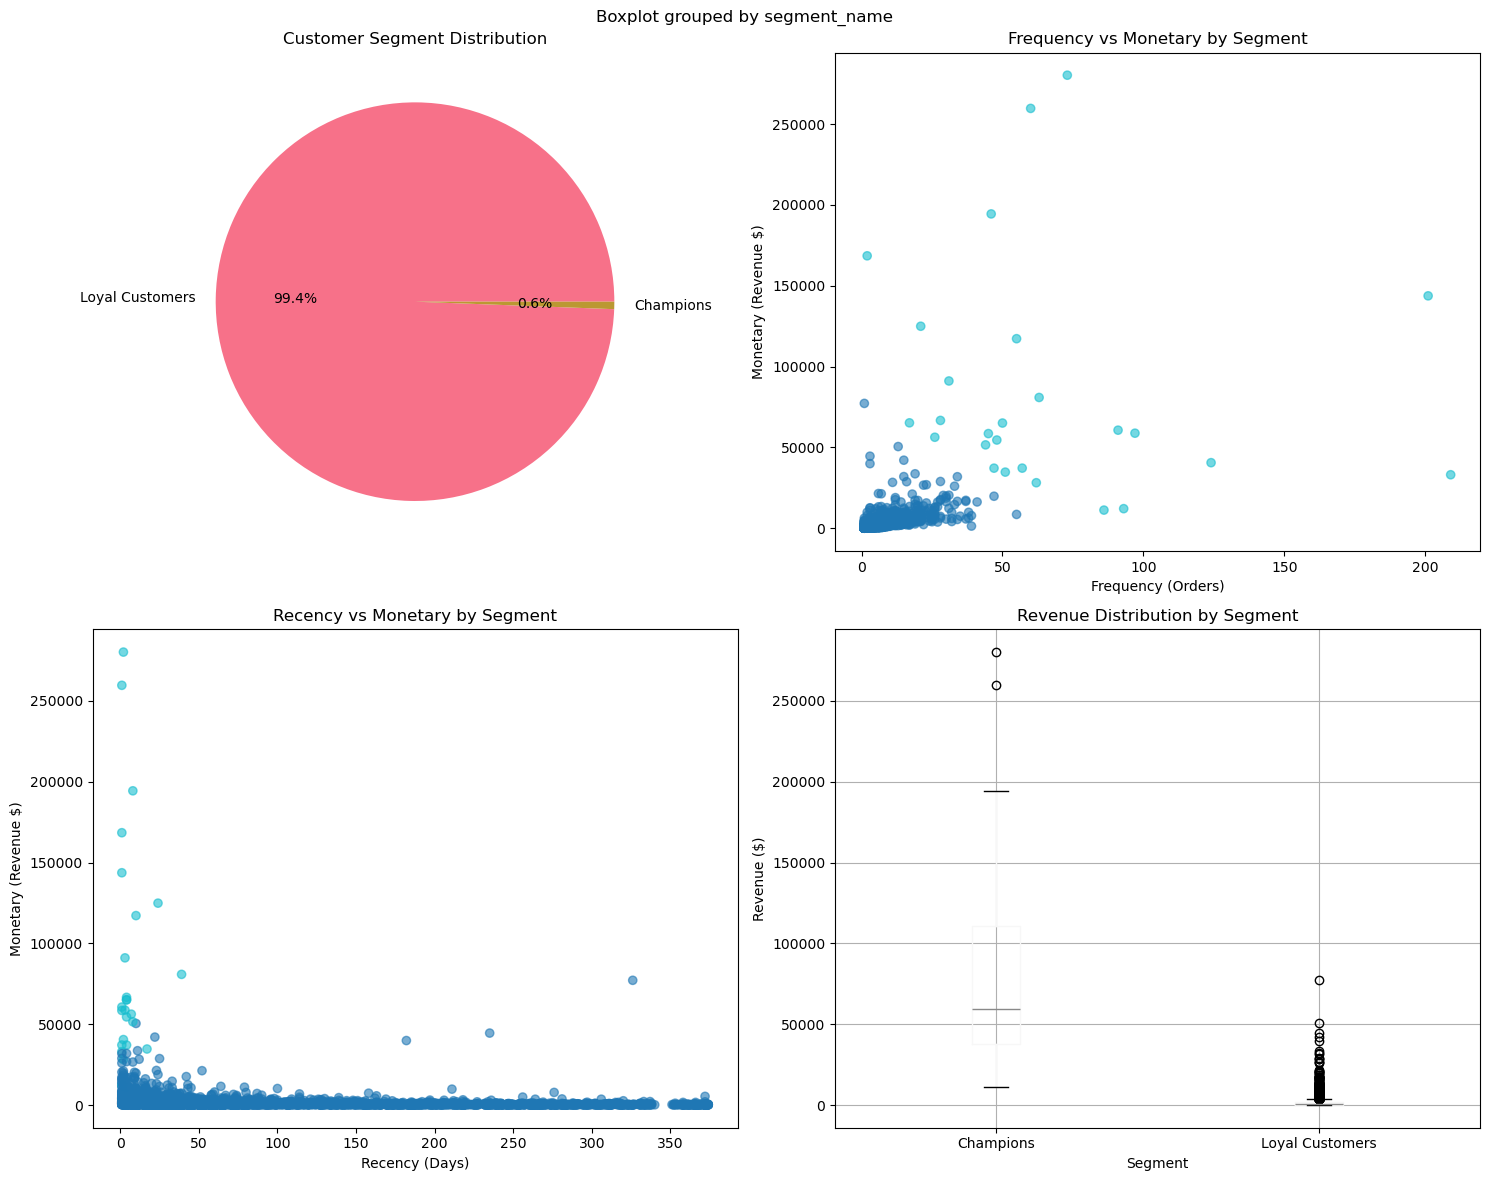


=== High-CLTV Customer Identification ===
CLTV Threshold (Top 10%): 2828.07
Number of high-CLTV customers: 434

High-CLTV Customer Profile:
Average Recency: 6.7 days
Average Frequency: 17.1 orders
Average Monetary: $11,241.32
Primary segments: {'Loyal Customers': 408, 'Champions': 26}


In [9]:
# Visualize segments
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Segment distribution
segment_counts = rfm['segment_name'].value_counts()
ax1.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
ax1.set_title('Customer Segment Distribution')

# RFM scatter plots colored by segment
scatter = ax2.scatter(rfm['frequency'], rfm['monetary'], c=rfm['segment'], alpha=0.6, cmap='tab10')
ax2.set_xlabel('Frequency (Orders)')
ax2.set_ylabel('Monetary (Revenue $)')
ax2.set_title('Frequency vs Monetary by Segment')

# Recency vs Monetary
ax3.scatter(rfm['recency'], rfm['monetary'], c=rfm['segment'], alpha=0.6, cmap='tab10')
ax3.set_xlabel('Recency (Days)')
ax3.set_ylabel('Monetary (Revenue $)')
ax3.set_title('Recency vs Monetary by Segment')

# Box plot of monetary values by segment
rfm.boxplot(column='monetary', by='segment_name', ax=ax4)
ax4.set_title('Revenue Distribution by Segment')
ax4.set_xlabel('Segment')
ax4.set_ylabel('Revenue ($)')

plt.tight_layout()
plt.savefig('../visuals/segment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== High-CLTV Customer Identification ===")

# Simple CLTV proxy and top 10% identification
rfm['cltv_proxy'] = rfm['frequency'] * rfm['monetary'] / rfm['recency']
cltv_threshold = rfm['cltv_proxy'].quantile(0.9)

print(f"CLTV Threshold (Top 10%): {cltv_threshold:.2f}")
print(f"Number of high-CLTV customers: {(rfm['cltv_proxy'] >= cltv_threshold).sum():,}")

# High-CLTV customer characteristics
high_cltv = rfm[rfm['cltv_proxy'] >= cltv_threshold]
print(f"\nHigh-CLTV Customer Profile:")
print(f"Average Recency: {high_cltv['recency'].mean():.1f} days")
print(f"Average Frequency: {high_cltv['frequency'].mean():.1f} orders")
print(f"Average Monetary: ${high_cltv['monetary'].mean():,.2f}")
print(f"Primary segments: {high_cltv['segment_name'].value_counts().head(3).to_dict()}")

In [11]:
# Save results
print("\n=== Saving Results ===")

# Save customer segments
customer_segments = rfm.reset_index()
customer_segments['cltv_proxy'] = customer_segments['cltv_proxy']
customer_segments['high_cltv'] = customer_segments['cltv_proxy'] >= cltv_threshold

customer_segments.to_csv('../data/customer_segments.csv', index=False)
print("✅ Customer segments saved to ../data/customer_segments.csv")

# Save segment summary
segment_summary_final = segment_summary.reset_index()
segment_summary_final['segment_name'] = segment_summary_final['segment'].map(segment_names)
segment_summary_final.to_csv('../data/segment_summary.csv', index=False)
print("✅ Segment summary saved to ../data/segment_summary.csv")

print(f"\n🎯 DAY 3 COMPLETE!")
print(f"✅ {optimal_k} customer segments identified")
print(f"✅ {len(customer_segments):,} customers segmented") 
print(f"✅ {(customer_segments['high_cltv']).sum():,} high-CLTV customers identified")
print(f"✅ Business actions defined for each segment")


=== Saving Results ===
✅ Customer segments saved to ../data/customer_segments.csv
✅ Segment summary saved to ../data/segment_summary.csv

🎯 DAY 3 COMPLETE!
✅ 2 customer segments identified
✅ 4,338 customers segmented
✅ 434 high-CLTV customers identified
✅ Business actions defined for each segment
